In [1]:
from google.colab import files
files.upload() # kaggle.jsonをアップロード
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 87.1MB/s]
Archive:  malware-analysis-datasets-pe-section-headers.zip
  inflating: pe_section_headers.csv  
          hash  size_of_data  virtual_address   entropy
0       9662.0        5120.0           4096.0  6.057597
1      39578.0      443392.0           4096.0  6.529624
2      30013.0       25600.0           4096.0  6.421738
3      14307.0      262144.0           4096.0  6.638142
4      15804.0      717824.0           4096.0  7.737879
...        ...           ...              ...       ...
43088  34422.0       21504.0           4096.0  6.379587
43089  28699.0       31744.0           4096.0  6.431134
43090  42998.0      513024.0           4096.0  6.539181
43091  42199.0       12800.0           4096.0  6.234855
43092  25376.0      306688.0           4096.0  6.248331

[43093 rows x 4 columns]

Without Sampling


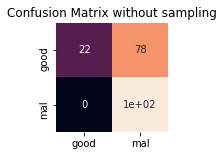

              precision    recall  f1-score   support

        good       1.00      0.22      0.36       100
         mal       0.56      1.00      0.72       100

    accuracy                           0.61       200
   macro avg       0.78      0.61      0.54       200
weighted avg       0.78      0.61      0.54       200

Accuracy:	0.610
Precision:	0.562
Recall :	1.000

Sampling Type: RUS


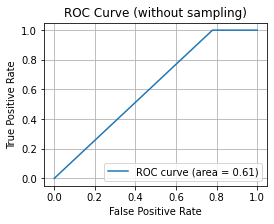

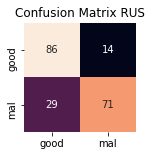

              precision    recall  f1-score   support

        good       0.75      0.86      0.80       100
         mal       0.84      0.71      0.77       100

    accuracy                           0.79       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.79      0.78       200

Accuracy:	0.785
Precision:	0.835
Recall :	0.710

Sampling Type: ENN


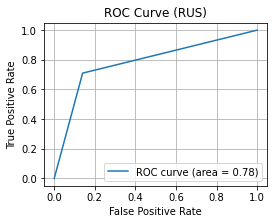

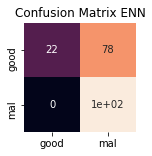

              precision    recall  f1-score   support

        good       1.00      0.22      0.36       100
         mal       0.56      1.00      0.72       100

    accuracy                           0.61       200
   macro avg       0.78      0.61      0.54       200
weighted avg       0.78      0.61      0.54       200

Accuracy:	0.610
Precision:	0.562
Recall :	1.000

Sampling Type: ROS


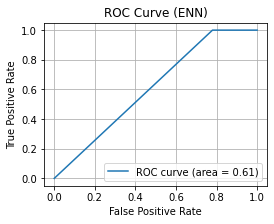

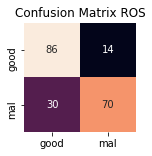

              precision    recall  f1-score   support

        good       0.74      0.86      0.80       100
         mal       0.83      0.70      0.76       100

    accuracy                           0.78       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.78      0.78       200

Accuracy:	0.780
Precision:	0.833
Recall :	0.700

Sampling Type: SMOTE


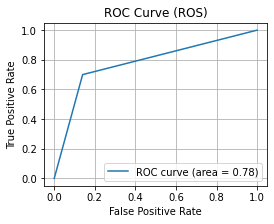

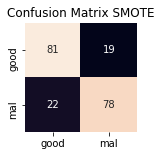

              precision    recall  f1-score   support

        good       0.79      0.81      0.80       100
         mal       0.80      0.78      0.79       100

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.79       200

Accuracy:	0.795
Precision:	0.804
Recall :	0.780

Sampling Type: ADASYN


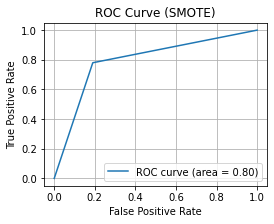

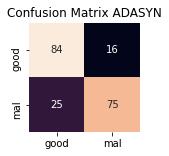

              precision    recall  f1-score   support

        good       0.77      0.84      0.80       100
         mal       0.82      0.75      0.79       100

    accuracy                           0.80       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.80      0.79       200

Accuracy:	0.795
Precision:	0.824
Recall :	0.750


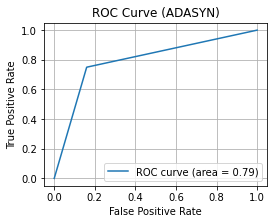

In [1]:
# プログラム2.6

import numpy as np
import pandas as pd
import random
# ROC曲線の描画用にインポート
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# 混同行列の可視化(heatmap)用にインポート
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, \
confusion_matrix, classification_report, \
roc_curve, roc_auc_score
# ラベルエンコーディング用にインポート
from sklearn.preprocessing import LabelEncoder
# 不均衡データを扱うライブラリのインストール
# (Google Colabにインストール済みのものはバージョンが古い)
!pip install imbalanced-learn==0.7.0
# アンダーサンプリング用ライブラリをインポート
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours
# オーバーサンプリング用ライブラリをインポート
from imblearn.over_sampling import SMOTE,\
 ADASYN, RandomOverSampler

# データの準備
def prepare(test_count):
    !kaggle datasets download -d \
    ang3loliveira/malware-analysis-datasets-pe-section-headers
    !unzip malware-analysis-datasets-pe-section-headers.zip
    # マルウェア判定の不均衡データを使用
    df_train = pd.read_csv('pe_section_headers.csv')
    # 分類に使用する特徴量
    features = [c for c in df_train.columns.values[:4]]
    le = LabelEncoder()
    # ハッシュ値の文字列をラベルエンコードする
    df_train['hash'] = le.fit_transform(df_train['hash'])
    X_train = df_train.loc[:,features].values
    y_train = df_train.loc[:,['malware']].values
    # 正例、負例をそれぞれtest_countずつ、テスト用とする
    # 残りのデータを学習データとする
    mal_ids = [i for i, e in enumerate(y_train) if e == 1]
    good_ids = [i for i, e in enumerate(y_train) if e == 0]
    random.seed(0)
    # インデックスをシャッフルし、データを並べ替える
    random.shuffle(mal_ids) 
    random.shuffle(good_ids)
    X_test = X_train[mal_ids[:test_count] + good_ids[:test_count]] 
    y_test = y_train[mal_ids[:test_count] + good_ids[:test_count]]
    X = X_train[mal_ids[test_count:] + good_ids[test_count:]] 
    y = y_train[mal_ids[test_count:] + good_ids[test_count:]]
    y = y.ravel()
    y_test = y_test.ravel()
    return X, y, X_test, y_test, features

# リサンプリング(ENN, RUS, SMOTE, ROS, ADASYNの5種類)
def sampling(sampling_type, X_train, y_train):
    print('\nSampling Type: %s' % sampling_type)
    if sampling_type == 'ENN':
      smp = EditedNearestNeighbours()
    elif sampling_type == 'RUS':
      smp = RandomUnderSampler()
    elif sampling_type == 'ROS':
      smp = RandomOverSampler()
    elif sampling_type == 'SMOTE':
      smp = SMOTE()
    elif sampling_type == 'ADASYN':
      smp = ADASYN()
    X_r, y_r = smp.fit_resample(X_train, y_train)
    return X_r, y_r

# 結果の表示（混同行列、ROC曲線を表示）
def disp_result(y_test, y_pred, sampling_type):
    target_names=['good', 'mal']
    cmx = confusion_matrix(y_test, y_pred, labels=[0,1])
    df_cmx = pd.DataFrame(cmx, index=target_names, columns=target_names)
    plt.figure(figsize = (2,2))
    # 混同行列をヒートマップで可視化
    hm = sns.heatmap(df_cmx,annot=True, cbar=False)
    plt.title('Confusion Matrix {}'.format(sampling_type))
    plt.savefig('conf_mat_{}.png'.format(sampling_type), dpi=500)
    plt.show()
    hm.get_figure().savefig('cmx_{}.png'.format(
                            sampling_type),
                            bbox_inches='tight')
    print(classification_report(y_test, y_pred,
   target_names=target_names))
    tn, fp, fn, tp = cmx.ravel()
    print( '{:<7}:\t{:>.3f}'.format('Accuracy', accuracy_score(y_test, y_pred)))
    print( '{:<7}:\t{:>.3f}'.format('Precision', tp / (tp + fp)))
    print( '{:<7}:\t{:>.3f}'.format('Recall', tp / (tp + fn)))
    # ROC曲線のためにFPR, TPRを取得
    # しきい値thresholdを取得 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # AUC(area under the curve)を計算
    auc_score = roc_auc_score(y_test, y_pred)
    # ROC曲線を描画
    plt.figure(figsize=(4,3))
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' % auc_score)
    plt.legend()
    plt.title('ROC Curve ({})'.format(sampling_type))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.savefig('ROC_CURVE_{}.png'.format(sampling_type), bbox_inches='tight', dpi=500)
    
def main():
    test_count = 100
    X_train, y_train, X_test, y_test, features = prepare(test_count)
    df_train = pd.DataFrame(X_train, columns=features)
    print(df_train)
    # リサンプリングを行わずに、ランダムフォレストで学習・予測
    rf = RandomForestClassifier(max_depth=5, random_state=0)
    rf.fit(X_train, y_train)
    print('\nWithout Sampling')
    y_pred = rf.predict(X_test)
    disp_result(y_test, y_pred, 'without sampling')
    # 5種類のリサンプリングを行い、
    # ランダムフォレストで学習・予測
    for sampling_type in ['RUS', 'ENN', 
                           'ROS', 'SMOTE', 'ADASYN']:
        X_r, y_r = sampling(sampling_type, X_train, y_train)
        rf = RandomForestClassifier(max_depth=5, random_state=0)
        rf.fit(X_r, y_r)
        y_pred = rf.predict(X_test)
        disp_result(y_test, y_pred, sampling_type)

if __name__ == '__main__':
    main()
